<a href="https://colab.research.google.com/github/takzen/pytorch-black-belt/blob/main/notebooks/24_Weight_Initialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --------------------------------------------------------------
# ☁️ COLAB SETUP (Automatyczna instalacja środowiska)
# --------------------------------------------------------------
import sys
import os

# Sprawdzamy, czy jesteśmy w Google Colab
if 'google.colab' in sys.modules:
    print('☁️ Wykryto środowisko Google Colab. Konfiguruję...')

    # 1. Pobieramy plik requirements.txt bezpośrednio z repozytorium
    !wget -q https://raw.githubusercontent.com/takzen/ai-engineering-handbook/main/requirements.txt -O requirements.txt

    # 2. Instalujemy biblioteki
    print('⏳ Instaluję zależności (to może chwilę potrwać)...')
    !pip install -q -r requirements.txt

    print('✅ Gotowe! Środowisko jest zgodne z repozytorium.')
else:
    print('💻 Wykryto środowisko lokalne. Zakładam, że masz już uv/venv.')


# 🥋 Lekcja 24: Inicjalizacja Wag (Kaiming vs Xavier)

Gdy tworzysz `nn.Linear`, PyTorch używa domyślnej inicjalizacji (zazwyczaj Kaiming Uniform). Ale gdy budujesz niestandardowe warstwy lub używasz egzotycznych funkcji aktywacji, musisz wiedzieć, jak ustawić wagi.

**Problem:**
1.  **Exploding Gradients:** Jeśli wagi są za duże, sygnał rośnie wykładniczo z każdą warstwą. Na końcu dostajesz `NaN`.
2.  **Vanishing Gradients:** Jeśli wagi są za małe, sygnał zanika do zera. Sieć się nie uczy.

**Cel:** Chcemy, aby **wariancja** (rozrzut) sygnału na wejściu sieci była taka sama jak na wyjściu.

Zbudujemy głęboką sieć (50 warstw) i sprawdzimy histogramy aktywacji.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Konfiguracja
LAYERS = 50
HIDDEN_DIM = 512

# Dane wejściowe (Batch=512, Features=512)
x = torch.randn(512, HIDDEN_DIM)

print(f"Testujemy sieć o głębokości {LAYERS} warstw.")

Testujemy sieć o głębokości 50 warstw.


## Eksperyment 1: Naiwna Inicjalizacja (Normalna)

Ustawimy wagi losowo z rozkładu normalnego $N(0, 0.01)$.
Wydaje się to rozsądne, prawda? Małe liczby bliskie zera.

Zobaczmy, co stanie się z sygnałem po przejściu przez 50 warstw mnożenia macierzy.

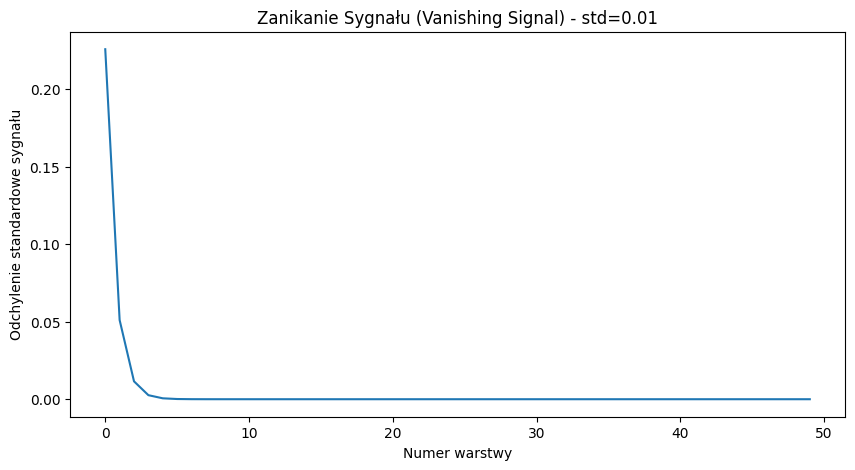

Sygnał na wejściu: 1.0
Sygnał na wyjściu: 5.759234654833978e-33
Wniosek: Sygnał umarł. Sieć jest martwa.


In [2]:
class BadNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(HIDDEN_DIM, HIDDEN_DIM) for _ in range(LAYERS)])
        
        # Ręczna, naiwna inicjalizacja
        for layer in self.layers:
            nn.init.normal_(layer.weight, mean=0.0, std=0.01) # Małe liczby
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        activations = []
        for layer in self.layers:
            x = layer(x)
            activations.append(x.std().item()) # Zapisujemy odchylenie standardowe
        return activations

model_bad = BadNet()
stds_bad = model_bad(x)

# Wykres
plt.figure(figsize=(10, 5))
plt.plot(stds_bad)
plt.title("Zanikanie Sygnału (Vanishing Signal) - std=0.01")
plt.xlabel("Numer warstwy")
plt.ylabel("Odchylenie standardowe sygnału")
plt.show()

print(f"Sygnał na wejściu: 1.0")
print(f"Sygnał na wyjściu: {stds_bad[-1]}")
print("Wniosek: Sygnał umarł. Sieć jest martwa.")

## Eksperyment 2: Kaiming Initialization (He Init)

Kaiming He (twórca ResNet) zauważył, że przy funkcji **ReLU**, połowa sygnału jest zerowana. Żeby zachować energię (wariancję), wagi muszą być nieco większe.

Wzór na odchylenie standardowe wag:
$$ \text{std} = \sqrt{\frac{2}{\text{fan\_in}}} $$
gdzie `fan_in` to liczba wejść do neuronu.

Użyjemy wbudowanej funkcji `nn.init.kaiming_normal_`.

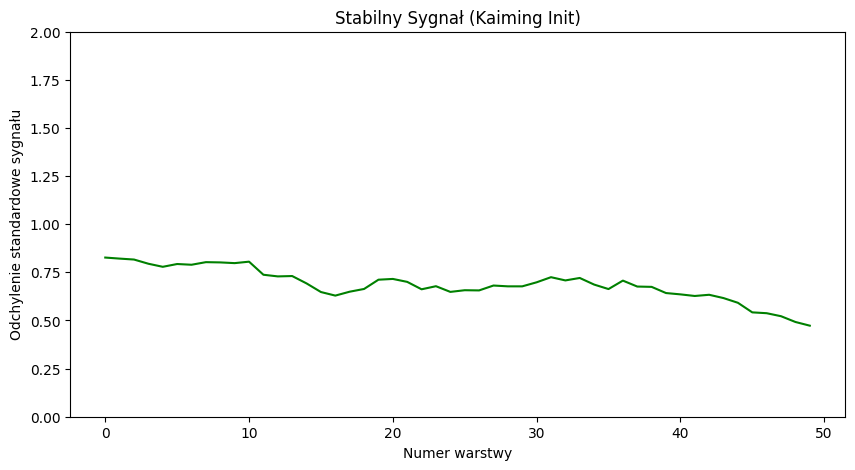

Sygnał na wejściu: 1.0
Sygnał na wyjściu: 0.4730
Wniosek: Sygnał przetrwał 50 warstw! Sieć będzie się uczyć.


In [3]:
class GoodNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(HIDDEN_DIM, HIDDEN_DIM) for _ in range(LAYERS)])
        self.relu = nn.ReLU()
        
        # Inicjalizacja Kaiming
        for layer in self.layers:
            # mode='fan_in' (zachowaj wariancję w przód)
            # nonlinearity='relu' (uwzględnij, że ReLU zeruje połowę)
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        activations = []
        for layer in self.layers:
            x = self.relu(layer(x)) # Ważne: Teraz mamy nieliniowość!
            activations.append(x.std().item())
        return activations

model_good = GoodNet()
stds_good = model_good(x)

# Wykres
plt.figure(figsize=(10, 5))
plt.plot(stds_good, color='green')
plt.title("Stabilny Sygnał (Kaiming Init)")
plt.xlabel("Numer warstwy")
plt.ylabel("Odchylenie standardowe sygnału")
plt.ylim(0, 2.0) # Żeby zobaczyć skalę
plt.show()

print(f"Sygnał na wejściu: 1.0")
print(f"Sygnał na wyjściu: {stds_good[-1]:.4f}")
print("Wniosek: Sygnał przetrwał 50 warstw! Sieć będzie się uczyć.")

## Gain (Wzmocnienie)

PyTorch ma funkcję `calculate_gain`, która mówi: *"O ile muszę pomnożyć wagi, żeby skompensować działanie danej funkcji aktywacji?"*.

*   Dla `Identity` (Linear) -> Gain = 1.
*   Dla `ReLU` -> Gain = $\sqrt{2} \approx 1.41$ (bo ucina połowę, więc resztę trzeba wzmocnić).
*   Dla `Tanh` -> Gain = $5/3 \approx 1.67$.

In [4]:
print("--- WSPÓŁCZYNNIKI WZMOCNIENIA (GAIN) ---")
print(f"Linear: {torch.nn.init.calculate_gain('linear'):.2f}")
print(f"ReLU:   {torch.nn.init.calculate_gain('relu'):.2f}")
print(f"Tanh:   {torch.nn.init.calculate_gain('tanh'):.2f}")
print(f"Sigmoid: {torch.nn.init.calculate_gain('sigmoid'):.2f}")

print("\nTo dlatego przy ReLU wagi muszą być większe niż przy funkcji liniowej.")

--- WSPÓŁCZYNNIKI WZMOCNIENIA (GAIN) ---
Linear: 1.00
ReLU:   1.41
Tanh:   1.67
Sigmoid: 1.00

To dlatego przy ReLU wagi muszą być większe niż przy funkcji liniowej.


## 🥋 Black Belt Summary

1.  **Domyślna inicjalizacja:** `nn.Linear` i `nn.Conv2d` w PyTorch używają **Kaiming Uniform** domyślnie. W 90% przypadków nie musisz nic robić.
2.  **Kiedy zmieniać?**
    *   Gdy używasz nietypowej aktywacji (np. `GeLU`, `Swish`).
    *   Gdy Twoja sieć jest bardzo głęboka (ResNet bez Residuals umarłby bez Kaiming Init).
3.  **Zasada:**
    *   Używasz **ReLU/LeakyReLU** -> `nn.init.kaiming_normal_`.
    *   Używasz **Sigmoid/Tanh** -> `nn.init.xavier_normal_` (znane też jako Glorot).